In [214]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scanpy.api as sc
import pandas as pd
import h5py
import os
import time
import itertools
from sklearn.decomposition import PCA

## Network
from community import community_louvain
import networkx as nx
import matplotlib.pyplot as plt

from util import *
import data_loader as dl
import scdd as sd
import dist_deconv_1d as dd1d

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.cm as cm

# Computation of the zero probability and the Pearson correlation matrix

In [277]:
data = dl.load_10x_4k()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [278]:
gene_list_raw = np.array(data.var_names)
sc.pp.filter_genes(data,min_counts=0.1*data.shape[0])
Nc,G,Nr,Nr_bar = sd.get_info(data)

## Nc=4340, G=4039, Nr=4038.76, Nr_bar=1.00


In [279]:
M_ml,M_dd = sd.dd_1d_moment(data,size_factor=size_factor)
cv_dd = sd.M_to_cv(M_dd)
cv_ml = sd.M_to_cv(M_ml)

#time start: 0.0s
n_cell=4340, n_gene=4039
#total: 0.24s


In [201]:
np.sum(np.diag(PC_dd)==0)

1459

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


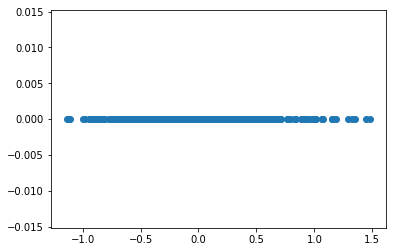

In [199]:
plt.figure()
plt.scatter(np.log10(mean_dd),np.log10(np.diag(PC_dd)))
plt.show()

In [280]:
n_top_gene = 2000
sort_idx = np.argsort(cv_dd)[::-1][0:n_top_gene]
gene_list = []
for i in sort_idx:
    gene_list.append(data.var_names[i])

In [281]:
data = data[:,gene_list]

In [282]:
data

View of AnnData object with n_obs × n_vars = 4340 × 2000 
    var: 'n_counts'

In [283]:
## MI using inactive probability 
size_factor = sd.dd_size_factor(data,verbose=False)
p0_ml,p0_dd = sd.dd_inactive_prob(data,relative_depth=1.25,size_factor=size_factor,verbose=True)
zero_matrix_ml,zero_matrix_dd = \
sd.dd_pairwise_inactive_prob(data,relative_depth=1.25,size_factor=size_factor,verbose=True)
smi_ml = sd.zero_to_mi(zero_matrix_ml,up_reg_gene=True) # zero probability to mi matrix 
smi_dd = sd.zero_to_mi(zero_matrix_dd,up_reg_gene=True)

# time start: 0.0s
n_cell=4340, n_gene=2000
# total time: 0.2s
# time start: 0.0s
n_cell=4340, n_gene=2000
# total time: 36.4s


In [223]:
## Compute the PC matrix 
# def preprocess(data):
#     data_ = data.copy()
#     A = data_.X.data
#     cap = np.percentile(A,99)
#     A = A.clip(max=cap)
#     data_.X.data = A
#     return data_

# data_full = preprocess(data)
# data_full = data.copy()
# size_factor = sd.dd_size_factor(data,verbose=False)
# mean_ml,cov_ml,PC_ml  = sd.ml_covariance(data,size_factor=size_factor)
mean_dd,cov_dd,PC_dd  = sd.dd_covariance(data,size_factor=size_factor,PC_prune=True)


#time start: 0.0s
n_cell=4340, n_gene=2133, Nr=3770.6
1405
#total: 25.84s


In [229]:
gene_list = list(data.var_names)
temp = 1 - PC_dd
temp = temp * (temp<0.4)
np.fill_diagonal(temp,0)
outfile = pwd+'gene_net_PCdd_test.csv'
write_NET_csv(temp,gene_list,outfile)

In [286]:
# gene_list = list(data.var_names)
temp = np.exp(-smi_dd*20)
temp = temp * (temp<0.75)
np.fill_diagonal(temp,0)
outfile = pwd+'gene_net_midd_test.csv'
write_NET_csv(temp,gene_list,outfile)

In [305]:
gene_list.index('CD74')

309

In [311]:
zero_matrix_ml[[1,546]][:,[1,546]]

array([[0.97695853, 0.1016129 ],
       [0.1016129 , 0.10299539]])

In [300]:
np.sum(zero_matrix_ml[546]<0.05)

88

In [292]:
plt.figure()
plt.hst(p0_dd)
plt.show()

0.06290410132847155

In [304]:
for i in np.arange(len(gene_list))[zero_matrix_ml[546]<0.03]:
    print(gene_list[i])

CD74
HLA-DRA
FTL
FTH1
LTB
CXCR4
JUN
CD37
DUSP1
FOS
JUNB
GAPDH
TSC22D3
ACTB
CYBA
ACTG1
MYL12A
OAZ1
H3F3A
SH3BGRL3
EVL
UBB
HLA-A
MT-CO1
H3F3B
TXNIP
PFN1
MT-CO3
MT-CO2
MT-ND3
MT-ND1
MT-ATP6
HLA-C
BTG1
ARPC3
MYL6
MT-ND4
ITM2B
CD52
MT-CYB
SARAF


In [302]:
np.sum(zero_matrix_ml[546]<0.03)

41

In [289]:
p0_dd[546]

0.06290410132847155

In [285]:
temp = np.exp(-smi_dd*20)
np.sum(temp<0.75)

32298

In [268]:
len(gene_list)

2133

In [269]:
np.sum

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [8]:
gene_list_ = np.array(data.var_names)

In [13]:
def get_PC_dd(cov_dd,mean_dd,PC_prune=1):
    ## clip the variance estimation to be 0: ???
    diag_cov_dd = np.diag(cov_dd)
    
    ## bad indeces
    index_bad = np.zeros([G],dtype=bool)
    index_bad[diag_cov_dd<=0.005] = True
#     index_bad[(diag_cov_dd/mean_dd)<0.05] = True
        
    print(np.sum(index_bad))
    #plt.figure()
    #plt.hist(diag_cov_dd/mean_dd,bins=np.linspace(0,2,101))
    #plt.show()
    
    np.fill_diagonal(cov_dd,diag_cov_dd.clip(min=1e-12))
        
    ## Pearson correlation
    std_dd = np.sqrt(diag_cov_dd)    
    #std_dd = np.sqrt(diag_cov_dd)
    std_dd = std_dd.reshape([G,1])
    PC_dd = cov_dd/(std_dd.dot(std_dd.T))
    PC_dd = PC_dd.clip(min=-1,max=1)
    
    ## for the bad index, remove the estimation: ???
    if PC_prune:
        PC_dd[:,index_bad] = 0
        PC_dd[index_bad,:] = 0
    return PC_dd

In [14]:
PC_dd = get_PC_dd(cov_dd,mean_dd)

407


# gene_net

In [186]:
pwd='./figures/figure_gene_network_VN/'

In [178]:
import csv
def write_NET_csv(knn,gnames,outfile):
    adj_csv = []
    adj_csv= [['']+[i for i in gnames]]
    for i in range(knn.shape[0]):
        adj_csv+= [ [gnames[i]]+[j for j in knn[:,i]]  ]

    myFile = open(outfile, 'w')
    with myFile:
        writer = csv.writer(myFile,delimiter=';')
        writer.writerows(adj_csv)

In [111]:
def rnn(D,t,metric='similarity',weight=False):
    A=np.zeros_like(D)
    if metric=='similarity':
        np.fill_diagonal(D,0) #exclude self
        A=D>t
        np.fill_diagonal(A,0)
        return np.array(A,dtype=int)
    elif metric=='distance':
        np.fill_diagonal(D,np.max(D)+1) #exclude self
        if weight:
            for i in range(D.shape[0]):
                neigh = np.where(D[:,i]<t)[0]
                A[neigh,i] = D[neigh,i]
            return np.array(A,dtype=float)
        else:
            A=D<t
            np.fill_diagonal(A,0)
            return np.array(A,dtype=int)
    else:
        print('error')
        return -1    

In [84]:
def knn(D,k=10,metric='similarity',weight=False):
    if metric=='similarity':
        np.fill_diagonal(D,0) #exclude self
        A=np.zeros_like(D)
        for i in range(D.shape[0]):
            neigh = np.argsort(D[:,i])[::-1][:k]
            A[neigh,i] = 1
        np.fill_diagonal(A,0)
        return A
    elif metric=='distance':
        np.fill_diagonal(D,np.max(D)+1) #exclude self
        A=np.zeros_like(D)
        for i in range(D.shape[0]):
            neigh = np.argsort(D[:,i])[:k]
            if weight:
                A[neigh,i] = D[neigh,i]
            else:
                A[neigh,i] = 1
        np.fill_diagonal(A,0)
        return A
    else:
        print('error')
        return -1       

### MI_dd

In [39]:
nnz=(smi_dd.sum(axis=1)>0)
D=smi_dd[:,nnz][nnz,:]
gene_list_D =gene_list_[nnz]

In [54]:
A=knn(D,k=10)

In [55]:
outfile=pwd+'gene_net_MIdd_k10.csv'
write_NET_csv(A,gene_list_D,outfile)

In [80]:
A=rnn(D,t=0.01)
print((A.sum(axis=1)>0).sum())

798


In [75]:
nnz=(A.sum(axis=1)>0)
R=A[:,nnz][nnz,:]
gene_list_R =gene_list_D[nnz]
outfile=pwd+'gene_net_MIdd_r0_01.csv'
write_NET_csv(R,gene_list_R,outfile)

### PC_dd

In [97]:
PC_dd = get_PC_dd(cov_dd,mean_dd)
nnz=(PC_dd.sum(axis=1)>0)
D=PC_dd[:,nnz][nnz,:]
gene_list_D =gene_list_[nnz]

print(D.shape)

407
(1424, 1424)


In [121]:
A=rnn(1-D,t=.1,metric='distance',weight=True)
print((A.sum(axis=1)>0).sum())

1377


In [122]:
np.sum(A>0)

29552

In [123]:
outfile=pwd+'gene_net_PCdd_r0_1_weight.csv'
write_NET_csv(A,gene_list_D,outfile)

# NAIVE approach

In [126]:
from scipy.spatial.distance import correlation
from sklearn.neighbors import NearestNeighbors

In [124]:
data4k = dl.load_10x_4k()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [127]:
nbrs = NearestNeighbors(n_neighbors=11, metric='correlation') 

In [128]:
bd=data4k.copy()


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [130]:
TOP_GENES=2000


sc.pp.filter_genes(bd, min_counts=0.025*bd.shape[0])  # only consider genes with more than xx counts
sc.pp.normalize_per_cell(bd)          # normalize with total UMI count per cell
filter_result = sc.pp.filter_genes_dispersion(bd.X, flavor='cell_ranger', n_top_genes=TOP_GENES,log=False)


In [131]:
bd = bd[:, filter_result.gene_subset]
sc.pp.normalize_per_cell(bd)

In [141]:
bd.X.shape

(4340, 2000)

In [136]:
bd.X = bd.X.todense()
nbrs.fit(bd.X.T) 
A = nbrs.kneighbors_graph(bd.X.T,mode='distance')

In [142]:
knn=np.array(A.toarray())
# knn[knn<1e-5] =0
knn[knn>0.9] =0

In [143]:
nnz=np.where((knn>0).sum(axis=0)>0)[0]
knn=knn[:,nnz][nnz,:]

In [144]:
knn.shape

(1034, 1034)

In [145]:
gnames=np.array(bd.var_names)[nnz]
outfile=pwd+'gene_net_naive.csv'
write_NET_csv(knn,gnames,outfile)

### 8k

In [146]:
data8k = dl.load_10x_8k()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [147]:
bd=data8k.copy()


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [148]:
TOP_GENES=2000


sc.pp.filter_genes(bd, min_counts=0.025*bd.shape[0])  # only consider genes with more than xx counts
sc.pp.normalize_per_cell(bd)          # normalize with total UMI count per cell
filter_result = sc.pp.filter_genes_dispersion(bd.X, flavor='cell_ranger', n_top_genes=TOP_GENES,log=False)


In [149]:
bd = bd[:, filter_result.gene_subset]
sc.pp.normalize_per_cell(bd)

In [150]:
bd.X.shape

(8381, 1999)

In [151]:
bd.X = bd.X.todense()
nbrs.fit(bd.X.T) 
A = nbrs.kneighbors_graph(bd.X.T,mode='distance')

In [152]:
knn=np.array(A.toarray())
# knn[knn<1e-5] =0
knn[knn>0.9] =0

In [153]:
nnz=np.where((knn>0).sum(axis=0)>0)[0]
knn=knn[:,nnz][nnz,:]

In [154]:
knn.shape

(878, 878)

In [155]:
gnames=np.array(bd.var_names)[nnz]
outfile=pwd+'gene_net_naive8k.csv'
write_NET_csv(knn,gnames,outfile)

In [313]:
import seaborn as sns

In [342]:
mean, cov = [0, 2], [(1, .5), (.5, 1)]
x, y = np.random.multivariate_normal(mean, cov, size=5000).T



mean, cov = [2, 0], [(1, .5), (.5, 1)]
z, w = np.random.multivariate_normal(mean, cov, size=500).T

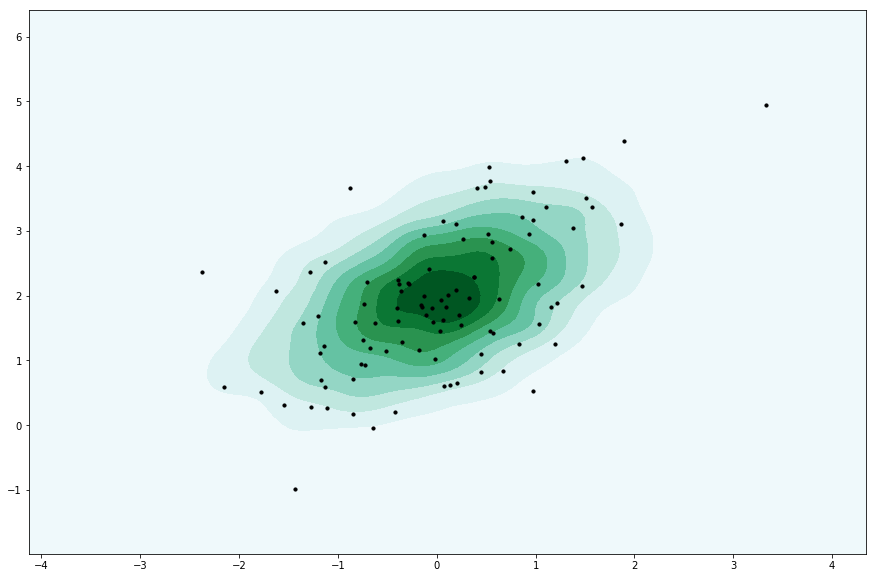

In [343]:
plt.figure(figsize=[15,10])
ax = sns.kdeplot(x, y, shade=1,alpha=1,shade_lowest=1)
ax=plt.scatter(x[:100],y[:100],s=10,color='k')

<Figure size 720x576 with 0 Axes>

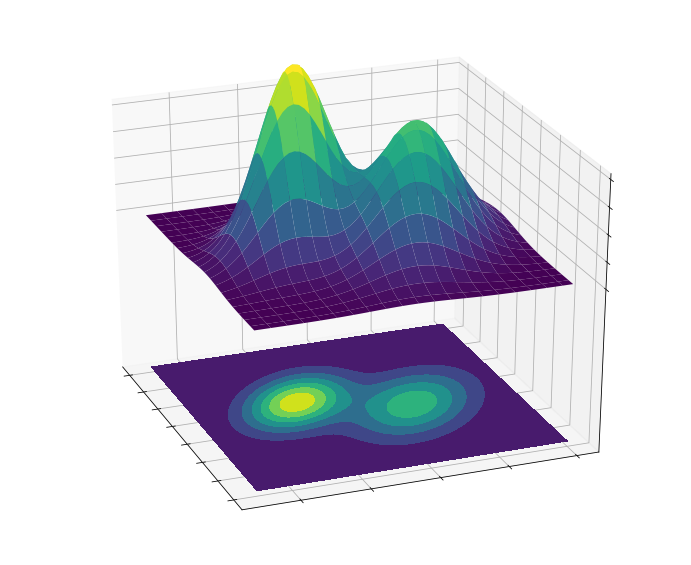

In [468]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

plt.figure(figsize=[10,8])

# Our 2-dimensional distribution will be over variables X and Y
N = 60
X = np.linspace(-4, 3, N)
Y = np.linspace(-5, 4, N)
X, Y = np.meshgrid(X, Y)

# Mean vector and covariance matrix
mu = np.array([0., 1.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])

mu2 = np.array([-1., -2.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  1.5]])


# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

# The distribution on the variables X, Y packed into pos.
Z = multivariate_gaussian(pos, mu, 1.2*Sigma)
Z2 = multivariate_gaussian(pos, mu2,0.85*Sigma)

# Create a surface plot and projected filled contour plot under it.
fig = plt.figure(figsize=[12,10])
ax = fig.gca(projection='3d')

cmap=cm.viridis


ax.plot_surface(X, Y, Z+Z2, rstride=3, cstride=3, linewidth=1, antialiased=True,
                cmap=cmap)

cset = ax.contourf(X, Y, Z+Z2, zdir='z', offset=-0.15, cmap=cmap)

# Adjust the limits, ticks and view angle
ax.set_zlim(-0.15,0.1)
ax.set_zticks(np.linspace(0,0.1,5))
ax.view_init(27, -21)

ax.set_xticklabels('')
ax.set_yticklabels('')
ax.set_zticklabels('')

plt.show()

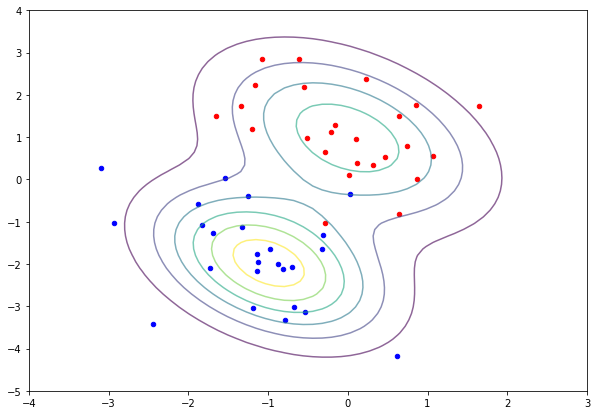

In [424]:
plt.figure(figsize=[10,7])
plt.contour(X, Y, Z+Z2, cmap=cmap,alpha=0.6)

ss=25
v=1

x, y = np.random.multivariate_normal(mu, v*Sigma, size=ss).T
ax=plt.scatter(x,y,s=20,color='r')

x, y = np.random.multivariate_normal(mu2, v*Sigma, size=ss).T
ax=plt.scatter(x,y,s=20,color='b')

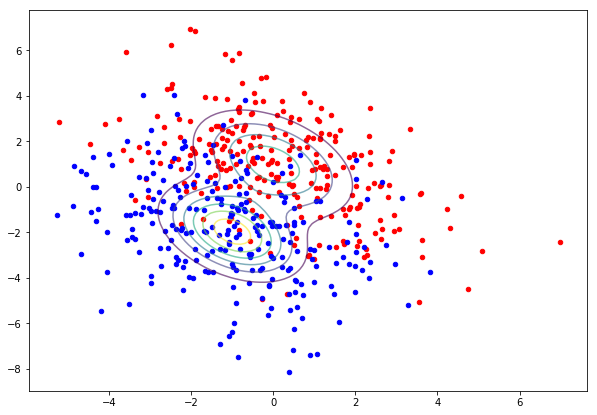

In [426]:
plt.figure(figsize=[10,7])
plt.contour(X, Y, Z+Z2, cmap=cmap,alpha=0.6)

ss=250
v=np.sqrt(10)

x, y = np.random.multivariate_normal(mu, v*Sigma, size=ss).T
ax=plt.scatter(x,y,s=20,color='r')

x, y = np.random.multivariate_normal(mu2, v*Sigma, size=ss).T
ax=plt.scatter(x,y,s=20,color='b')

In [469]:
for ss in range(5,200,20): print(ss)

5
25
45
65
85
105
125
145
165
185


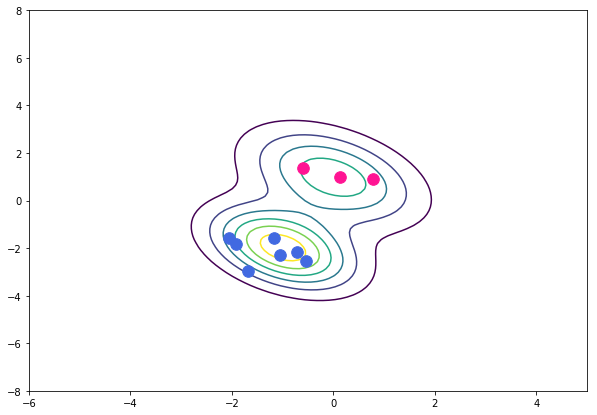

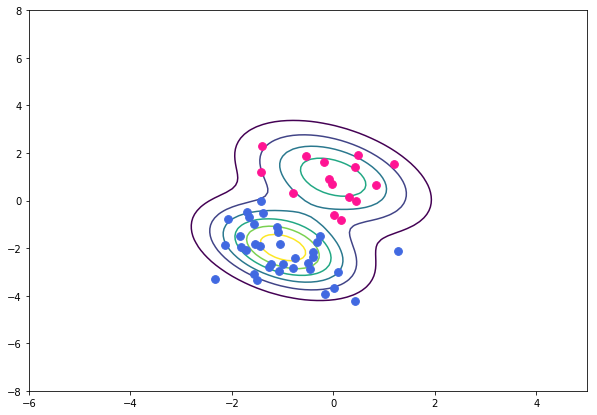

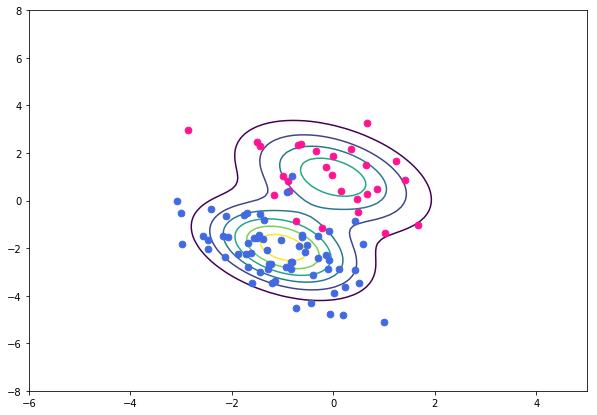

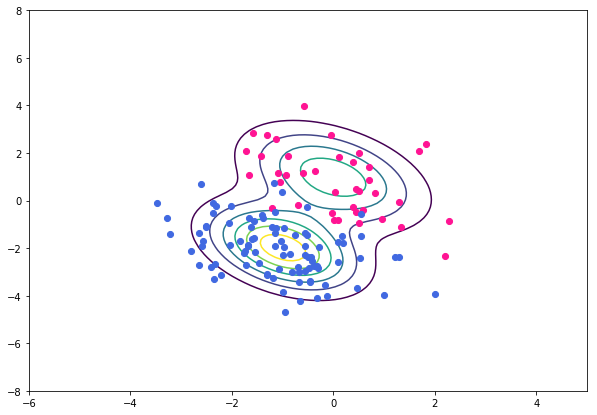

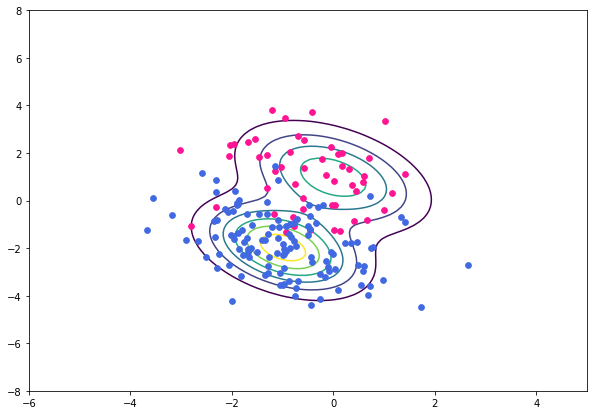

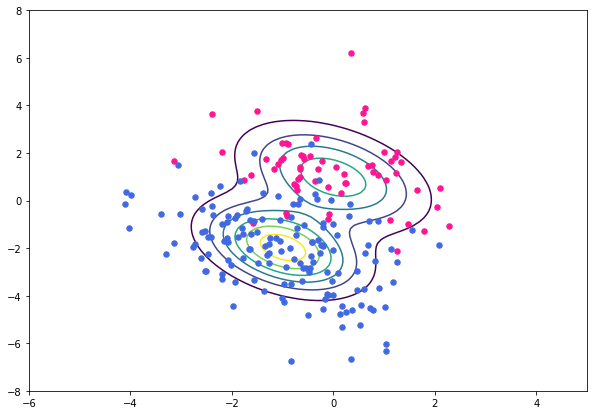

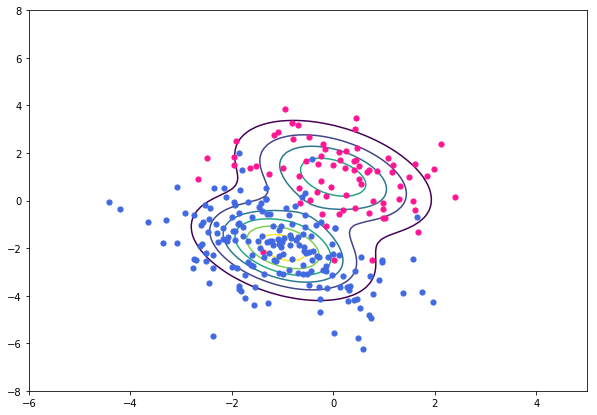

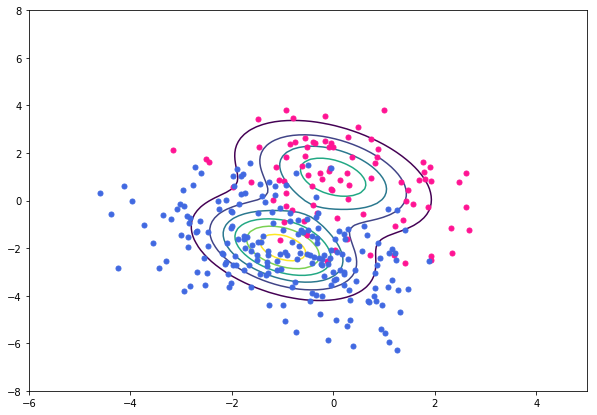

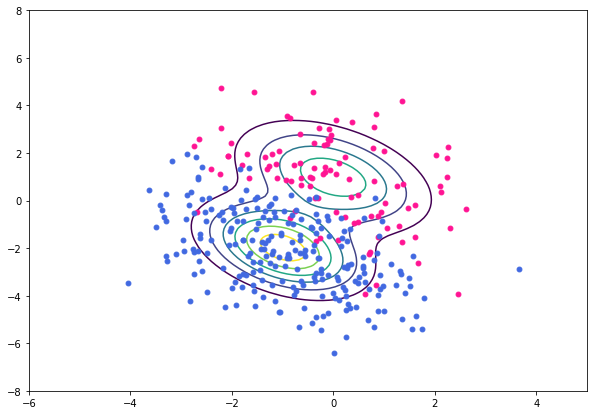

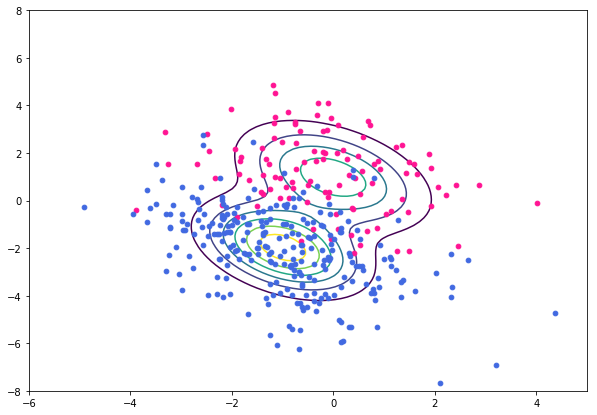

In [464]:
for ss in range(5,200,20):

    plt.figure(figsize=[10,7])
    plt.contour(X, Y, Z+Z2, cmap=cm.viridis,alpha=1,)

    
    v=np.sqrt(ss/50)

    x, y = np.random.multivariate_normal(mu, v*Sigma, size=int(np.round(2*0.3*ss))).T
    ax=plt.scatter(x,y,s=300/np.sqrt(ss),color='deeppink',zorder=10)

    x1, y1 = np.random.multivariate_normal(mu2, v*Sigma, size=int(np.round(2*0.7*ss))).T
    ax=plt.scatter(x1,y1,s=300/np.sqrt(ss),color='royalblue',zorder=10)
    
    

    
    
    plt.xlim([-6,5])
    plt.ylim([-8,8])
#     plt.axis('square')
    plt.show()
    
#     z=np.concatenate([x,x1])
#     w=np.concatenate([y,y1])
#     ax = sns.kdeplot(z, w, shade=1,alpha=1,shade_lowest=1)

In [461]:
np.round(2*0.3*ss)

6.0